
# Model Building Jupyter Notebook
This Jupyter Notebook serves as the main file for constructing machine learning models and building appropriate feature sets. The notebook is organized into four key sections:

### 1. Data Pre-Processing
In this section, we will ensure the data is adequately processed for model building. We will:

- Assess the current state of data processing.

- Identify any additional features that need to be added to improve model efficiency.
### 2. Model Building
- Here, we will develop the initial models that will be trained on the data processed in the previous section. This section focuses on:

- Constructing the models without fine-tuning or interpretation at this stage.
### 3. Model Training and Evaluation
In this section, we will:

- Train the models using the prepared data.

- Evaluate the performance of each model.

- Determine if the model outputs are reliable and worth further consideration.
### 4. Results
The final section will involve analyzing the decision-making process of the models. We will:

- Examine the results of linear regression models.

- For more advanced algorithms, delve into both local and global interpretations to understand the decision-making of these "black box" models.


### Setting up Enviornment 

In [128]:
import pandas as pd # This is to read csv files
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc # Classification Evaluation
from sklearn.linear_model import LogisticRegression # Logit Regression
import statsmodels.api as sm # For proper results interpretation of models
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler # Different type of scaling

# For LSTM Development 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import matplotlib.pyplot as plt # General Plotting

btc = pd.read_csv('data/model/btc_model_price.csv')

In [129]:
btc.columns

Index(['Tomorrow', 'Date', 'Price', 'Change %', 'Volume_pct_change',
       'Gold_pct_change', 'Gold_Volume_pct_change', 'SNP_pct_change',
       'VIX_pct_change', 'VIX_pct_change_pct_change',
       'Wikipedia_Views_pct_change', 'Google_Trends_pct_change',
       'TVL_pct_change', 'weighted_sentiment_pct_change', 'MA_td', '3MA_td',
       '%K_td', '%D_td', 'RSI_td', 'Momentum_td', 'MACD_td', 'CCI_td'],
      dtype='object')

##### Preparing the model dataset

In [130]:
# BTC - Only selecting required columns from the main dataset
btc.index = btc.Date
btc = btc[['Tomorrow','Change %', 'Volume_pct_change',
       'Gold_pct_change', 'Gold_Volume_pct_change', 'SNP_pct_change',
       'VIX_pct_change', 'VIX_pct_change_pct_change',
       'Wikipedia_Views_pct_change', 'Google_Trends_pct_change',
       'TVL_pct_change', 'weighted_sentiment_pct_change', 'MA_td', '3MA_td',
       '%K_td', '%D_td', 'RSI_td', 'Momentum_td', 'MACD_td', 'CCI_td']]

btc = btc.dropna()

#### Making lagged variables for non time series models 

In [131]:
variables = [var for var in btc.columns if var != 'Tomorrow']  # Adjust this if you only want to create lags for specific variables

num_lags = 3

btc_1 = btc.copy()
# Adding n lagged variables for each variable in the DataFrame
for var in variables: # value set to twelce as indepdent variable is the last column out of a total 13
    for lag in range(1, num_lags+1):
        btc_1[f'{var}_lag{lag}'] = btc_1[var].shift(lag)

# Optional: Remove rows with NaN values that result from shifting
btc_1.dropna(inplace=True)

# Replace inf and -inf with NaN
btc_1.replace([np.inf, -np.inf], np.nan, inplace=True)
btc_1.dropna(inplace=True)


btc_1.columns

Index(['Tomorrow', 'Change %', 'Volume_pct_change', 'Gold_pct_change',
       'Gold_Volume_pct_change', 'SNP_pct_change', 'VIX_pct_change',
       'VIX_pct_change_pct_change', 'Wikipedia_Views_pct_change',
       'Google_Trends_pct_change', 'TVL_pct_change',
       'weighted_sentiment_pct_change', 'MA_td', '3MA_td', '%K_td', '%D_td',
       'RSI_td', 'Momentum_td', 'MACD_td', 'CCI_td', 'Change %_lag1',
       'Change %_lag2', 'Change %_lag3', 'Volume_pct_change_lag1',
       'Volume_pct_change_lag2', 'Volume_pct_change_lag3',
       'Gold_pct_change_lag1', 'Gold_pct_change_lag2', 'Gold_pct_change_lag3',
       'Gold_Volume_pct_change_lag1', 'Gold_Volume_pct_change_lag2',
       'Gold_Volume_pct_change_lag3', 'SNP_pct_change_lag1',
       'SNP_pct_change_lag2', 'SNP_pct_change_lag3', 'VIX_pct_change_lag1',
       'VIX_pct_change_lag2', 'VIX_pct_change_lag3',
       'VIX_pct_change_pct_change_lag1', 'VIX_pct_change_pct_change_lag2',
       'VIX_pct_change_pct_change_lag3', 'Wikipedia_Vie

##### Initializing Training and Test Datasets

In [132]:
btc_1.head(5)

,Tomorrow,Change %,Volume_pct_change,Gold_pct_change,Gold_Volume_pct_change,SNP_pct_change,VIX_pct_change,VIX_pct_change_pct_change,Wikipedia_Views_pct_change,Google_Trends_pct_change,...,RSI_td_lag3,Momentum_td_lag1,Momentum_td_lag2,Momentum_td_lag3,MACD_td_lag1,MACD_td_lag2,MACD_td_lag3,CCI_td_lag1,CCI_td_lag2,CCI_td_lag3
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-24,1,-0.0459,56.055901,0.0057,-52.380952,-0.0031,0.0098,-126.630435,12.329969,9.375000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2024-06-23,0,-0.0166,-83.466003,-0.0161,0.000000,-0.0016,-0.0060,-161.224490,-17.675781,-37.142857,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-22,0,0.0021,-11.985958,-0.0161,0.000000,-0.0016,-0.0060,0.000000,0.260973,4.545455,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2024-06-21,1,-0.0112,246.780627,-0.0161,0.000000,-0.0016,-0.0060,0.000000,8.778987,17.391304,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2024-06-20,0,-0.0019,-7.591193,0.0060,38.333333,-0.0025,0.0641,-1168.333333,1.631499,0.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0


In [133]:
# Get all column names except 'Tomorrow'
columns = btc_1.drop(columns='Tomorrow').columns.tolist()

# Select the columns for X
X = btc_1[columns]
y = btc_1['Tomorrow']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled features back to DataFrame for VIF calculation and to retain column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Split data into training and test sets while respecting the temporal order
split_index = int(len(btc_1) * 0.8)
X_train, X_test = X_scaled_df[:split_index], X_scaled_df[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Convert scaled features back to DataFrame for VIF calculation
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
# Calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]
vif["features"] = X_scaled_df.columns

vif.head(5)

,VIF Factor,features
0,2.991386,Change %
1,3.996078,Volume_pct_change
2,2.128409,Gold_pct_change
3,2.987677,Gold_Volume_pct_change
4,4.178993,SNP_pct_change


In [50]:
# Check for inf values
if np.isinf(X).values.any():
    print("There are inf values in the dataset.")

# Check for NaN values
if np.isnan(X).values.any():
    print("There are NaN values in the dataset.")

#### Model 1: RandomForest Regression

In [150]:
from sklearn.ensemble import RandomForestClassifier

rfm = RandomForestClassifier(n_estimators=350,  bootstrap=True, max_depth=13, min_samples_split=5)
rfm.fit(X_train, y_train)
rf_pred = rfm.predict(X_test)

In [151]:
# Evaluate the model
accuracy = accuracy_score(y_test, rf_pred)
conf_matrix = confusion_matrix(y_test, rf_pred)
class_report = classification_report(y_test, rf_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9411764705882353
Confusion Matrix:
[[18  0]
 [ 2 14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.88      0.93        16

    accuracy                           0.94        34
   macro avg       0.95      0.94      0.94        34
weighted avg       0.95      0.94      0.94        34



ROC Curve to test model evaluation

###### The ROC (Receiver Operating Characteristic) curve is a graphical representation used to evaluate the performance of a classification model. It plots the true positive rate (sensitivity) against the false positive rate (1-specificity) across various threshold settings. The curve illustrates the trade-off between sensitivity and specificity: as one increases, the other may decrease. The area under the curve (AUC) provides a single scalar value to summarize the model's ability to distinguish between the positive and negative classes, with an AUC of 1 indicating perfect classification and an AUC of 0.5 suggesting no better than random chance. Thus, the ROC curve and AUC are valuable tools for assessing and comparing the discriminatory power of different classifiers.

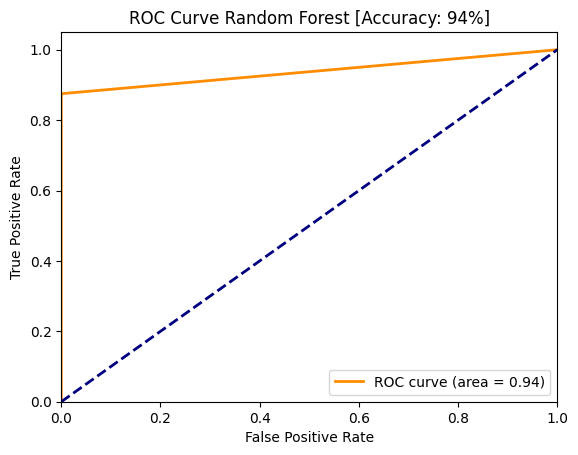

In [153]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, rf_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Random Forest [Accuracy: 94%]')
plt.legend(loc="lower right")
plt.show()

#### Model 2: Support Vector Machine (SVM)

In [138]:
from sklearn.svm import SVC

model = SVC(kernel='rbf', C = 4, probability=True)
model.fit(X_train, y_train)

svm_pred = model.predict(X_test)

In [139]:
# Evaluate the model
accuracy = accuracy_score(y_test, svm_pred)
conf_matrix = confusion_matrix(y_test, svm_pred)
class_report = classification_report(y_test, svm_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.8823529411764706
Confusion Matrix:
[[17  1]
 [ 3 13]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       0.93      0.81      0.87        16

    accuracy                           0.88        34
   macro avg       0.89      0.88      0.88        34
weighted avg       0.89      0.88      0.88        34



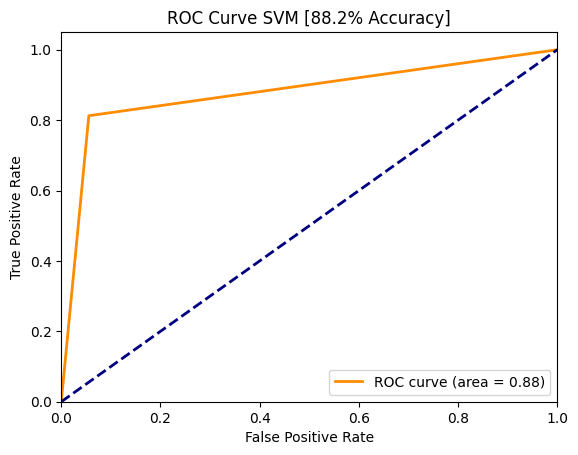

In [154]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, svm_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM [88.2% Accuracy]')
plt.legend(loc="lower right")
plt.show()

In [155]:
import shap 

# Create and fit the explainer
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

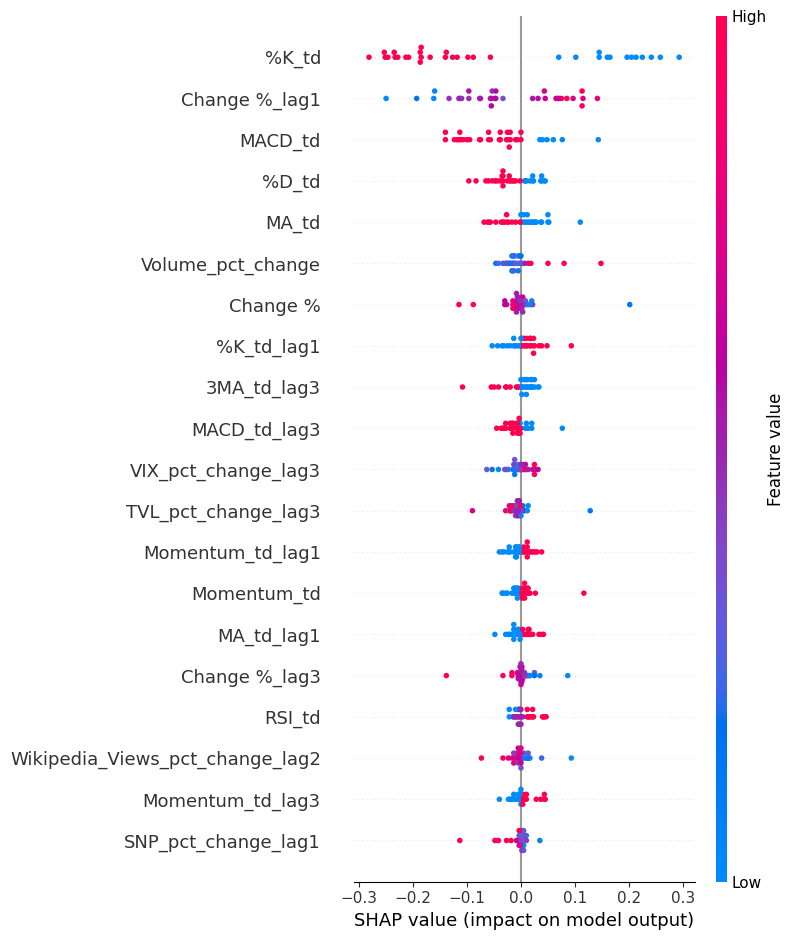

In [156]:
 shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.tolist())

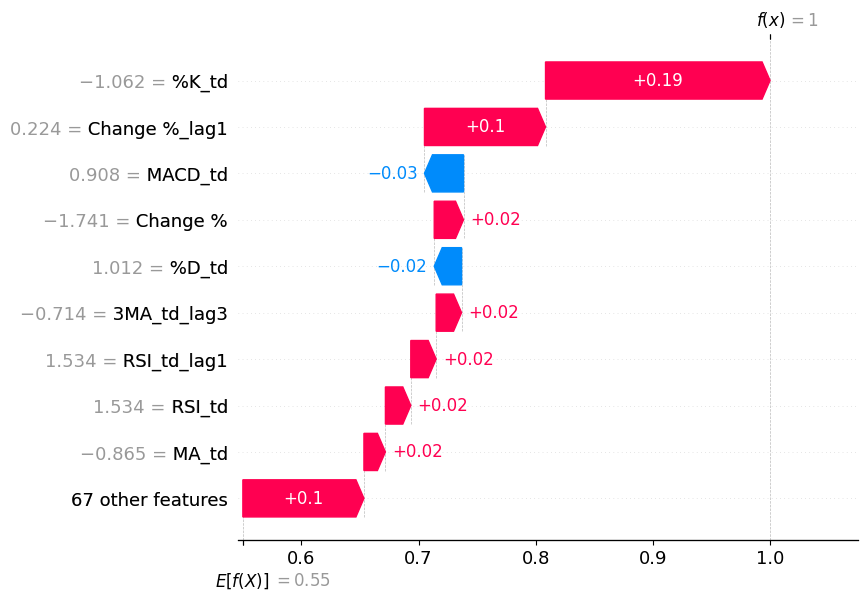

The actual value for the 12th instance is: 1


In [94]:
shap.waterfall_plot(shap_values[12])

# Show the plot
plt.show()

# Fetch the actual value for the 12th instance from y_test
actual_value = y_test.iloc[12]  # Assuming y_test is a DataFrame or Series

print(f"The actual value for the 12th instance is: {actual_value}")

#### Model 3: Long Short Term Memory (LSTM)

In [158]:
btc.index = pd.to_datetime(btc.index)
btc_lstm = btc.sort_index()

btc_lstm.replace([np.inf, -np.inf], np.nan, inplace=True)
btc_lstm.dropna(inplace=True)


# Get all column names except 'Tomorrow'
columns = btc_lstm.drop(columns='Tomorrow').columns.tolist()

# Normalize the feature columns
feature_scaler = MinMaxScaler()
btc_lstm[columns] = feature_scaler.fit_transform(btc_lstm[columns])

# Normalize the target column separately
target_scaler = MinMaxScaler()
btc_lstm['Tomorrow'] = target_scaler.fit_transform(btc_lstm['Tomorrow'].values.reshape(-1, 1))
# Function to create sequences
def create_sequences(data, target, past_days):
    sequences = []
    labels = []
    for i in range(past_days, len(data)):
        sequences.append(data[i-past_days:i])
        labels.append(target[i])
    return np.array(sequences), np.array(labels)

# Extract the feature columns and the target column
feature_data = btc_lstm[columns].values
target_data = btc_lstm['Tomorrow'].values

# Create sequences with 3 past days
past_days = 3
X, y = create_sequences(feature_data, target_data, past_days)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reshape X for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(columns)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(columns)))

In [159]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(past_days, len(columns))))
#model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/home/erenmuller/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [160]:
# Fit the model
model.fit(X_train, y_train, epochs=120, batch_size=12, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions_lstm = model.predict(X_test)
predictions_lstm = target_scaler.inverse_transform(predictions_lstm)
y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))

print('Predicted vs Actual form the model')
print('')
# Display the first 10 predictions and actual values
for i in range(10):
    print(f'Predicted: {predictions_lstm[i][0]}, Actual: {y_test[i][0]}')

# Evaluate the model

binary_predictions = (predictions_lstm > 0.5).astype(int)
accuracy = accuracy_score(y_test, binary_predictions)
conf_matrix = confusion_matrix(y_test, binary_predictions)
class_report = classification_report(y_test, binary_predictions)
print('')
print('')
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Epoch 1/120


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4451 - val_loss: 0.2786
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2696 - val_loss: 0.2506
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2464 - val_loss: 0.2424
Epoch 4/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2364 - val_loss: 0.2406
Epoch 5/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2257 - val_loss: 0.2356
Epoch 6/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2315 - val_loss: 0.2370
Epoch 7/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2146 - val_loss: 0.2400
Epoch 8/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2241 - val_loss: 0.2482
Epoch 9/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2133 - val_loss: 0.2512
Epoch 10/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2188 - val_loss: 0.2427
Epoch 11/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2176 - val_loss: 0.2490
Epoch 12/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2025 - val_l

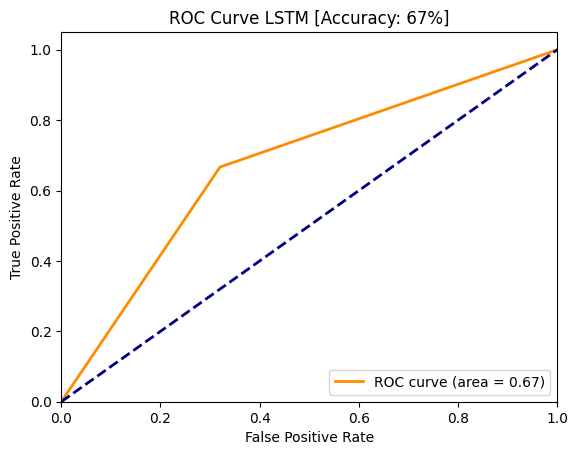

In [161]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, binary_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve LSTM [Accuracy: 67%]')
plt.legend(loc="lower right")
plt.show()

In [124]:
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import numpy as np

# Function to get the gradients of the model's output with respect to the input
def get_saliency_map(model, input_data, target_index):
    input_data = tf.convert_to_tensor(input_data)
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        prediction = model(input_data)
        loss = prediction[:, target_index]
    gradient = tape.gradient(loss, input_data)
    return gradient

# Get a single input sample to compute the saliency map
input_sample = X_test[7:8]

# Compute the saliency map for the sample
saliency_map = get_saliency_map(model, input_sample, 0).numpy().squeeze()


In [125]:
saliency = pd.DataFrame(saliency_map, columns=columns)
saliency = saliency.transpose()
saliency = saliency.sort_values(by=0, ascending=False)
saliency = saliency[:5]
saliency

,0,1,2
TVL_pct_change,0.574856,0.185929,-0.141080
Momentum_td,0.528229,0.211405,-0.217247
Wikipedia_Views_pct_change,0.459791,-0.355236,-0.687516
3MA_td,0.448691,0.260281,-0.081740
RSI_td,0.279466,0.179399,0.174366


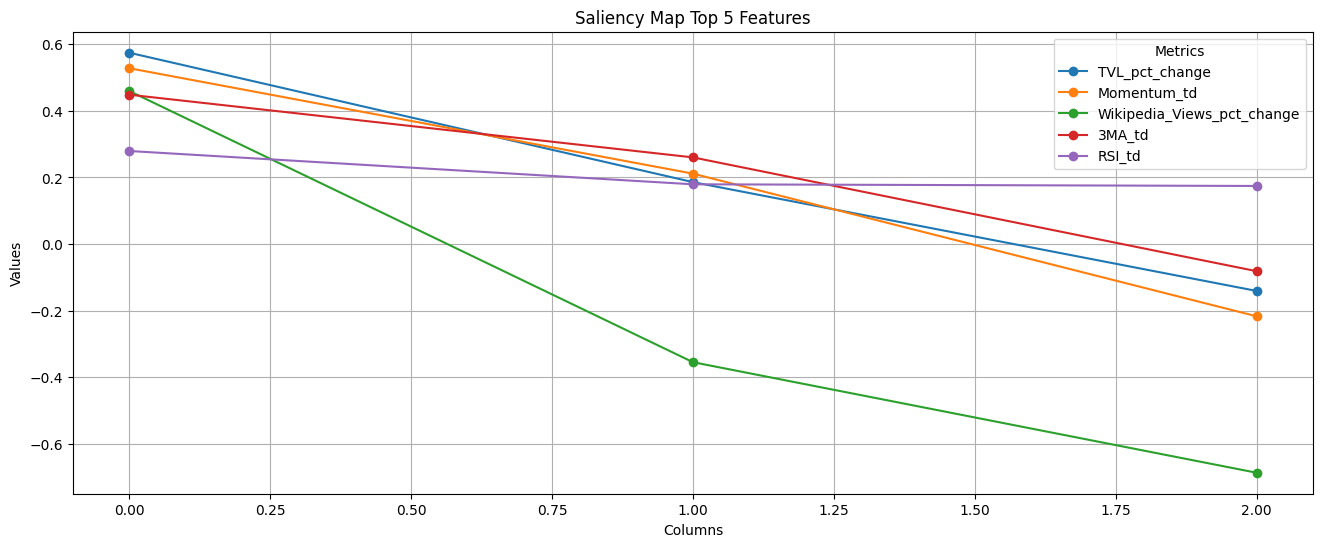

In [126]:
# Plot each row as a separate line chart
plt.figure(figsize=(16, 6))
for row in saliency.index:
    plt.plot(saliency.columns, saliency.loc[row], marker='o', label=row)
plt.title('Saliency Map Top 5 Features')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.legend(title='Metrics')
plt.grid(True)
plt.show()